In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
model=VGG16()
model.summary()

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
        '/content/Train/Train',
        batch_size = 1,
        target_size=(100, 100),
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/content/Test/Test',
        batch_size = 1,
        target_size=(100, 100),
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/content/Validation',
        batch_size = 1,
        target_size=(100, 100),
        class_mode='binary')

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 1 classes.


In [ ]:
train_dir = '/content/Train/Train'
test_dir = '/content/Test/Test'
validation_dir = '/content/Validation'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"/"+label):
        train_paths.append(train_dir+"/"+label+'/'+image)
        train_labels.append(label)


train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

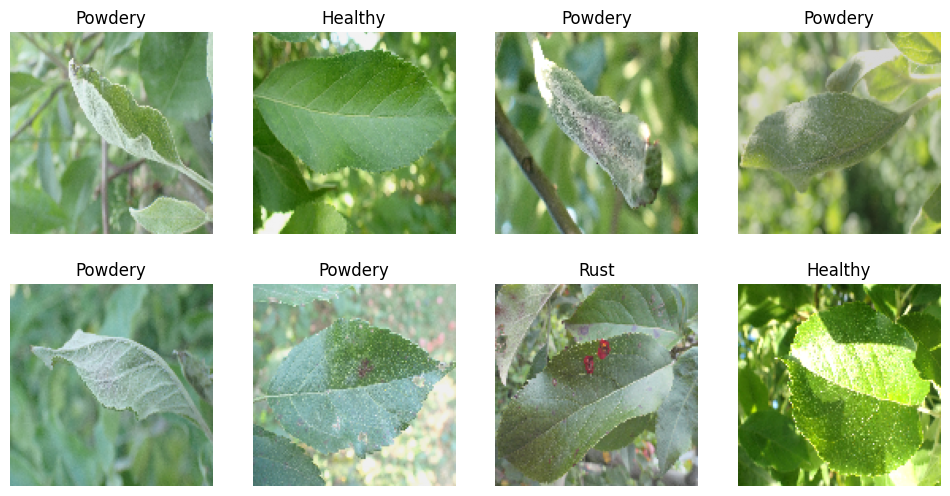

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

(2672, 4000, 3)

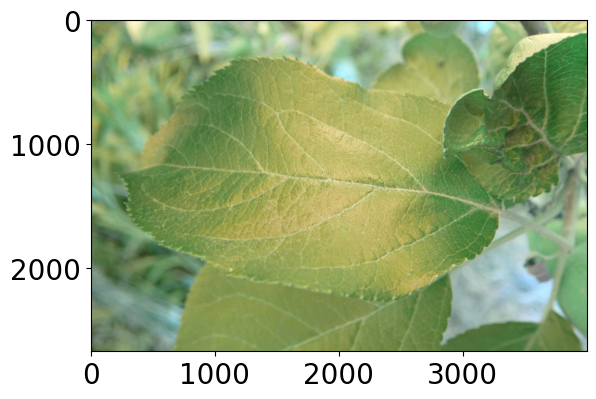

In [ ]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("/content/Test/Test/Healthy/8ddaa5a5caa5caa8.jpg")
plt.imshow(image)
image.shape

In [ ]:
from keras.applications import VGG16
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3))
model = Model(inputs = base_model.input, outputs = base_model.get_layer("fc1").output)

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 15763779 (60.13 MB)
Trainable params: 81

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [ ]:
batch_size = 16
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=16, epochs=10),
                    verbose=1,epochs=10, steps_per_epoch=steps)

Epoch 1/10
82/82 [==============================] - 409s 5s/step - loss: 0.6589 - accuracy: 0.7005
Epoch 2/10
82/82 [==============================] - 392s 5s/step - loss: 0.2250 - accuracy: 0.9181
Epoch 3/10
82/82 [==============================] - 395s 5s/step - loss: 0.1512 - accuracy: 0.9426
Epoch 4/10
82/82 [==============================] - 391s 5s/step - loss: 0.0972 - accuracy: 0.9694
Epoch 5/10
82/82 [==============================] - 377s 5s/step - loss: 0.0563 - accuracy: 0.9793
Epoch 6/10
82/82 [==============================] - 373s 5s/step - loss: 0.0431 - accuracy: 0.9832
Epoch 7/10
82/82 [==============================] - 373s 5s/step - loss: 0.0110 - accuracy: 0.9969
Epoch 8/10
82/82 [==============================] - 391s 5s/step - loss: 0.0198 - accuracy: 0.9939
Epoch 9/10
82/82 [==============================] - 372s 5s/step - loss: 0.0386 - accuracy: 0.9839
Epoch 10/10
82/82 [==============================] - 372s 5s/step - loss: 0.0516 - accuracy: 0.9832


In [ ]:
 def extract_features(train_dir, model):
    features = []
    labels = []
    class_names = sorted(os.listdir(train_dir))
    label_dict = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)
            features.append(model.predict(img_array))
            labels.append(label_dict[class_name])

    return np.vstack(features), np.array(labels)

features, labels = extract_features(train_dir, model)

def flatten_features(features):
    return features.reshape(features.shape[0], -1)

features = flatten_features(features)
print("Feature vector dimensions: ",features.shape)

1/1 [==============================] - 1s 583ms/step
Feature vector dimensions:  (1322, 1000)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(kernel='linear', C=1)

combined_data = np.column_stack((features,labels))

np.random.shuffle(combined_data)

features = combined_data[:, :-1]
labels = combined_data[:, -1]

split_ratio = 0.80
split_idx = int(len(features) * split_ratio)
train_features, test_features = features[:split_idx], features[split_idx:]
train_labels, test_labels = labels[:split_idx], labels[split_idx:]


clf.fit(train_features, train_labels)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.09%
